In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=MATIC&tsym=USDT&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')

target_col = 'close'



In [4]:
endpoint1 = 'https://min-api.cryptocompare.com/data/histoday'
res1 = requests.get(endpoint1 + '?fsym=SOL&tsym=USDT&limit=500')
hist1 = pd.DataFrame(json.loads(res1.content)['Data'])
hist1 = hist1.set_index('time')
hist1.index = pd.to_datetime(hist1.index, unit='s')
target_col1 = 'close'

In [5]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [6]:
hist1.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [7]:
hist.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-06-04,0.6001,0.5764,0.5891,6.237382e+07,36864683.10,0.5961
2022-06-05,0.6070,0.5842,0.5961,7.279023e+07,43266315.69,0.5979
2022-06-06,0.6558,0.5961,0.5979,1.486834e+08,94432946.02,0.6328
2022-06-07,0.6335,0.5842,0.6328,1.348834e+08,81335304.31,0.6171
2022-06-08,0.6326,0.6029,0.6171,6.479017e+07,39863296.71,0.6089


In [8]:
hist1.tail(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-06-04,39.42,35.75,38.28,4845083.87,1.810382e+08,39.00
2022-06-05,40.21,37.87,39.00,4881009.33,1.914040e+08,38.52
2022-06-06,44.73,38.34,38.52,9228516.09,3.923739e+08,42.39
2022-06-07,42.74,37.21,42.39,10203294.73,4.024715e+08,39.32
2022-06-08,40.91,38.30,39.32,3374113.01,1.324546e+08,38.99


In [9]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [10]:
train, test = train_test_split(hist, test_size=0.20)

In [11]:
len(train)

401

In [12]:
train1, test1 = train_test_split(hist1, test_size=0.20)

In [13]:
len(train1)

401

In [14]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(10, 5))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('Price [USDT]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

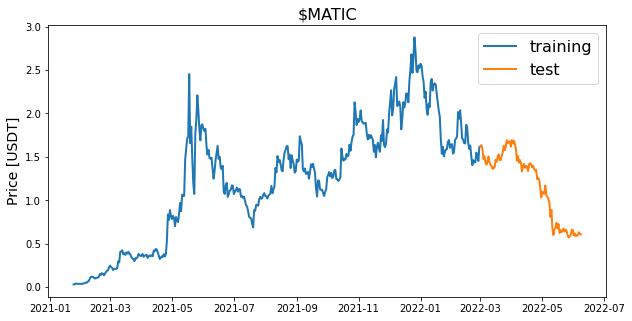

In [15]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='$MATIC')

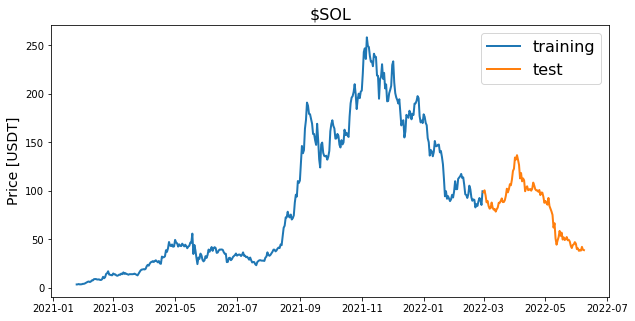

In [16]:
line_plot(train1[target_col1], test1[target_col1], 'training', 'test', title='$SOL')

In [17]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [18]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [19]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test

In [20]:
def build_lstm_model(input_data, output_size, neurons=150, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='rmsprop'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [128]:
np.random.seed(45)
window_len = 5
test_size = 0.20
zero_base = True
lstm_neurons = 150
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'rmsprop'

In [129]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [130]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/50
13/13 [==============================] - 7s 110ms/step - loss: 0.0423 - val_loss: 0.0099
Epoch 2/50
13/13 [==============================] - 0s 14ms/step - loss: 0.0298 - val_loss: 0.0083
Epoch 3/50
13/13 [==============================] - 0s 18ms/step - loss: 0.0276 - val_loss: 0.0058
Epoch 4/50
13/13 [==============================] - 0s 22ms/step - loss: 0.0249 - val_loss: 0.0053
Epoch 5/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0226 - val_loss: 0.0061
Epoch 6/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0226 - val_loss: 0.0081
Epoch 7/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0215 - val_loss: 0.0077
Epoch 8/50
13/13 [==============================] - 0s 16ms/step - loss: 0.0202 - val_loss: 0.0052
Epoch 9/50
13/13 [==============================] - 0s 29ms/step - loss: 0.0194 - val_loss: 0.0074
Epoch 10/50
13/13 [==============================] - 0s 21ms/step - loss: 0.0180 - val_loss: 0.0046
Epoch 11

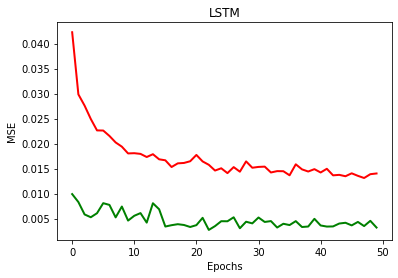

In [131]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [132]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.03882438658972421

In [133]:

from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds, y_test)
MSE


0.003197627524234453

In [134]:
import math
rmse = math.sqrt(MSE)
rmse

0.0565475686854391

In [135]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6862126543345302

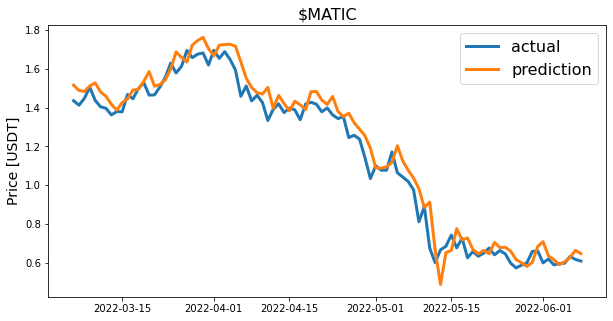

In [119]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds= pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', title ='$MATIC', lw=3)

In [100]:
np.random.seed(45)
window_len = 5
test_size = 0.20
zero_base = True
lstm_neurons1 = 150
epochs1 = 250
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'rmsprop'

In [101]:
train1, test1, X_train1, X_test1, y_train1, y_test1 = prepare_data(
    hist1, target_col1, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [102]:
model1 = build_lstm_model(
    X_train1, output_size=1, neurons=lstm_neurons1, dropout=dropout, loss=loss,
    optimizer=optimizer)
history1 = model1.fit(
    X_train1, y_train1, validation_data=(X_test1, y_test1), epochs=epochs1, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/250
13/13 [==============================] - 7s 113ms/step - loss: 0.0262 - val_loss: 0.0087
Epoch 2/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0162 - val_loss: 0.0072
Epoch 3/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0154 - val_loss: 0.0088
Epoch 4/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0134 - val_loss: 0.0064
Epoch 5/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0122 - val_loss: 0.0054
Epoch 6/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0122 - val_loss: 0.0073
Epoch 7/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0104 - val_loss: 0.0061
Epoch 8/250
13/13 [==============================] - 0s 16ms/step - loss: 0.0113 - val_loss: 0.0055
Epoch 9/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0098 - val_loss: 0.0053
Epoch 10/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0105 - val_loss: 0.004

13/13 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0038
Epoch 83/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 84/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0068 - val_loss: 0.0038
Epoch 85/250
13/13 [==============================] - 0s 21ms/step - loss: 0.0065 - val_loss: 0.0040
Epoch 86/250
13/13 [==============================] - 0s 23ms/step - loss: 0.0070 - val_loss: 0.0043
Epoch 87/250
13/13 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0047
Epoch 88/250
13/13 [==============================] - 0s 26ms/step - loss: 0.0072 - val_loss: 0.0038
Epoch 89/250
13/13 [==============================] - 0s 28ms/step - loss: 0.0067 - val_loss: 0.0037
Epoch 90/250
13/13 [==============================] - 0s 28ms/step - loss: 0.0068 - val_loss: 0.0044
Epoch 91/250
13/13 [==============================] - 0s 26ms/step - loss: 0.0069 - val_loss: 0.0037
Epo

13/13 [==============================] - 0s 28ms/step - loss: 0.0054 - val_loss: 0.0034
Epoch 163/250
13/13 [==============================] - 0s 21ms/step - loss: 0.0058 - val_loss: 0.0036
Epoch 164/250
13/13 [==============================] - 0s 13ms/step - loss: 0.0058 - val_loss: 0.0043
Epoch 165/250
13/13 [==============================] - 0s 12ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 166/250
13/13 [==============================] - 0s 11ms/step - loss: 0.0057 - val_loss: 0.0036
Epoch 167/250
13/13 [==============================] - 0s 10ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 168/250
13/13 [==============================] - 0s 14ms/step - loss: 0.0058 - val_loss: 0.0038
Epoch 169/250
13/13 [==============================] - 0s 10ms/step - loss: 0.0055 - val_loss: 0.0037
Epoch 170/250
13/13 [==============================] - 0s 16ms/step - loss: 0.0056 - val_loss: 0.0034
Epoch 171/250
13/13 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0

13/13 [==============================] - 0s 10ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 243/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0053 - val_loss: 0.0033
Epoch 244/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 245/250
13/13 [==============================] - 0s 15ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 246/250
13/13 [==============================] - 0s 16ms/step - loss: 0.0051 - val_loss: 0.0032
Epoch 247/250
13/13 [==============================] - 0s 14ms/step - loss: 0.0051 - val_loss: 0.0033
Epoch 248/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0052 - val_loss: 0.0032
Epoch 249/250
13/13 [==============================] - 0s 17ms/step - loss: 0.0050 - val_loss: 0.0035
Epoch 250/250
13/13 [==============================] - 0s 18ms/step - loss: 0.0052 - val_loss: 0.0033


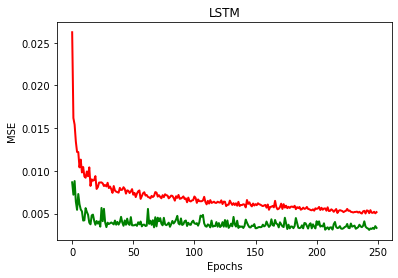

In [103]:
import matplotlib.pyplot as plt
plt.plot(history1.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history1.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [104]:
targets1 = test1[target_col1][window_len:]
preds1 = model1.predict(X_test1).squeeze()
mean_absolute_error(preds1, y_test1)

0.04488004433806298

In [105]:

from sklearn.metrics import mean_squared_error
MSE=mean_squared_error(preds1, y_test1)
MSE


0.003328542724737023

In [106]:
import math
rmse = math.sqrt(MSE)
rmse

0.05769352411438413

In [107]:
from sklearn.metrics import r2_score
R2=r2_score(y_test1, preds1)
R2

0.8064266659718409

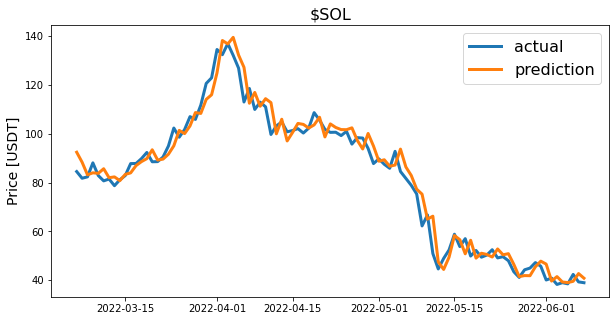

In [108]:
preds1 = test1[target_col1].values[:-window_len1] * (preds1 + 1)
preds1= pd.Series(index=targets1.index, data=preds1)
line_plot(targets1, preds1, 'actual', 'prediction', title ='$SOL', lw=3)


In [109]:
from keras.models import load_model    
model.save('Maticmodel.h5')  # creates a HDF5 file 'my_model.h5'
del model  # deletes the existing model

In [110]:
from keras.models import load_model
model1.save('Solmodel.h5')  # creates a HDF5 file 'my_model.h5'
del model1  # deletes the existing model